# Data Preprocessing

## import libraries

In [46]:
import numpy as np
import json
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from pyproj import Geod, Proj
from scipy.optimize import minimize

## loading the data
-location:
 latitude, longitude

-ping:
 ping time in ms

In [47]:
path = "./data/location_data.json"
ping_path = "./data/ping_mins.json"
us_anchors_path = "./data/us_anchors.json"
western_europe_anchors_path = "./data/western_europe_anchors.json"

loc_data = json.load(open(path))
ping_data = json.load(open(ping_path))
us_anchors = json.load(open(us_anchors_path))
western_europe_anchors = json.load(open(western_europe_anchors_path))

## choose the dataset
- US: United States
- WE: western europe

In [48]:
# "US" or "WE"
# Name = "US" 
Name = "US"
anchors = us_anchors if Name == "US" else western_europe_anchors
print(anchors)

['us-abn-as43996', 'us-abn-as51468', 'us-abn-as54054', 'us-atl-as2914', 'us-bcb-as1312', 'us-bos-as111', 'us-bos-as26167', 'us-cax-as14907', 'us-dal-as2914', 'us-dal-as7366', 'us-den-as7922', 'us-els-as40528', 'us-fcn-as32934', 'us-lan-as32244', 'us-lax-as15133', 'us-lax-as63403', 'us-ljl-as195', 'us-lwc-as2495', 'us-mia-as2914', 'us-mia-as33280', 'us-mnz-as30633', 'us-pao-as1280', 'us-pct-as88', 'us-phx-as53824', 'us-pou-as6124', 'us-qas-as14907', 'us-qas-as393246', 'us-rno-as3851', 'us-rtv-as16876', 'us-sea-as2914', 'us-sfo-as14061', 'us-sfo-as14907', 'us-sfo-as7203', 'us-sgu-as46309', 'us-sjc-as22300', 'us-wct-as7922']


## Visualization

longitude range: [-41.2905, 64.1385]
latitude range: [-123.1205, 175.3205]


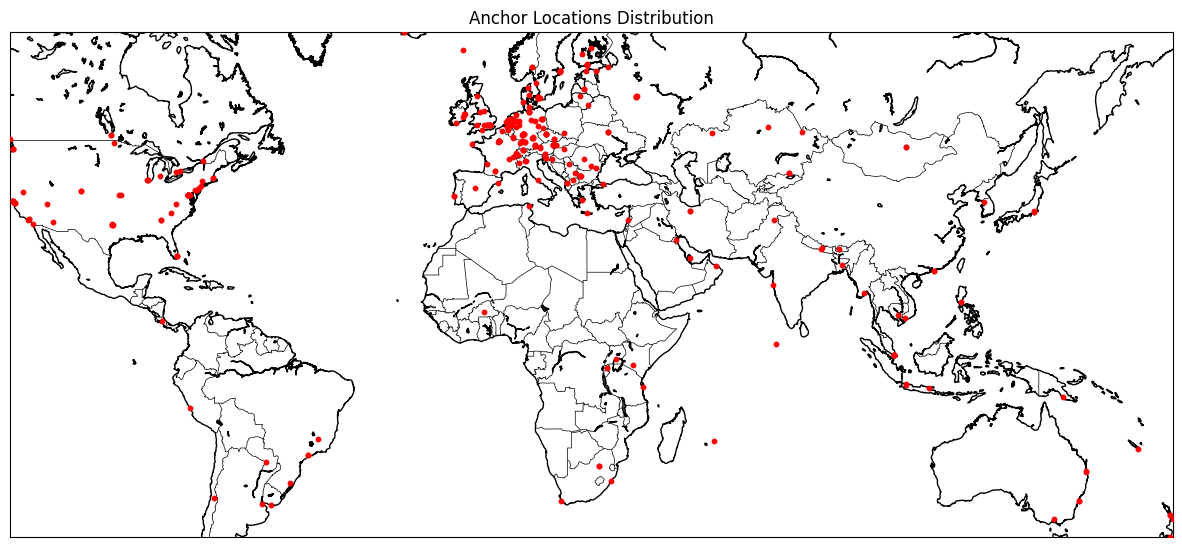

In [49]:
latitudes = []
longitudes = []
for key,value in loc_data.items():
    latitudes.append(value["lat"])
    longitudes.append(value["lng"])

min_lat = min(latitudes)
max_lat = max(latitudes)
min_lon = min(longitudes)
max_lon = max(longitudes)

print(f"longitude range: [{min_lat}, {max_lat}]")
print(f"latitude range: [{min_lon}, {max_lon}]")

plt.figure(figsize=(15, 10))
m = Basemap(projection='merc', resolution='l',
            llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat)

m.drawcoastlines()
m.drawcountries()

x, y = m(longitudes, latitudes)

m.scatter(x, y, marker='o', color='red', zorder=5,s=10)

plt.title('Anchor Locations Distribution')
plt.savefig("anchor_onlyrelevant.png")
plt.show()

# Get bestline for delay to distance
- how to calculate distance by latitude and longitude
- get all exist (distance, delay) pairs
- find the bestline

## distance calculation
- km
- using Albers Equal Area Conic projection

In [50]:

def distance_km(lon1, lat1, lon2, lat2):
    # most accurate 
    geod = Geod(ellps="WGS84") 
    distance_m = geod.inv(lon1, lat1, lon2, lat2)[2] 
    return distance_m / 1000

def get_standard_lat_lon(anchors,loc_data):
    latitudes = []
    longitudes = []
    for anchor in anchors:
        latitudes.append(loc_data[anchor]["lat"])
        longitudes.append(loc_data[anchor]["lng"])
    standard_lat1 = min(latitudes)
    standard_lat2 = max(latitudes)
    standard_lon0 = 1/2*(min(longitudes)+max(longitudes))
    return standard_lat1,standard_lat2,standard_lon0

def to_aea(lon,lat,standard_lat1,standard_lat2,standard_lon0):
    # km as unit
    proj = Proj(proj='aea', lat_1=standard_lat1, lat_2=standard_lat2, lon_0=standard_lon0)
    x, y = proj(lon, lat)
    x= x/1000
    y= y/1000
    return x,y

def to_lon_lat(x,y,standard_lat1,standard_lat2,standard_lon0):
    # km as unit
    x = x*1000
    y = y*1000
    proj = Proj(proj='aea', lat_1=standard_lat1, lat_2=standard_lat2, lon_0=standard_lon0)
    lon, lat = proj(x, y, inverse=True)
    return lon,lat
    
def distance_km_aea(lon1,lat1,lon2,lat2,standard_lat1,standard_lat2,standard_lon0):
    proj = Proj(proj='aea', lat_1=standard_lat1, lat_2=standard_lat2, lon_0=standard_lon0)
    x1, y1 = proj(lon1, lat1)
    x2, y2 = proj(lon2, lat2)
    distance_m = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    return distance_m / 1000

standard_lat1,standard_lat2,standard_lon0 = get_standard_lat_lon(anchors,loc_data)
print("find standard lat1, lat2, lon0",standard_lat1,standard_lat2,standard_lon0)

beijing = (39.9042, 116.4074)
shanghai = (31.2304, 121.4737)
distance = distance_km(beijing[1],beijing[0],shanghai[1],shanghai[0])
distance_aea = distance_km_aea(beijing[1],beijing[0],shanghai[1],shanghai[0],standard_lat1,standard_lat2,standard_lon0)
print(f"distance between beijing and shanghai: {distance} km")
print(f"distance between beijing and shanghai: {distance_aea} km")

find standard lat1, lat2, lon0 25.7805 47.6095 -96.741
distance between beijing and shanghai: 1065.8464894532135 km
distance between beijing and shanghai: 1077.3169944084073 km


## get all exist (distance, delay,target) for each anchor

In [51]:
def get_distance_delay_target(ping_data, loc_data, anchors):
    # Extract distance and delay data from ping_data and loc_data withing the given anchors
    anchor_distances_delays_targets = {}
    # err = 0
    standard_lat1,standard_lat2,standard_lon0 = get_standard_lat_lon(anchors,loc_data)
    for src in anchors:
        target_delays = ping_data.get(src, {})
        if not target_delays:
            continue
        for target, delays in target_delays.items():
            if target in anchors and src != target:
                # distance_aea = distance_km(loc_data[src]["lng"], loc_data[src]["lat"], loc_data[target]["lng"], loc_data[target]["lat"])
                distance_aea = distance_km_aea(loc_data[src]["lng"], loc_data[src]["lat"], loc_data[target]["lng"], loc_data[target]["lat"],standard_lat1,standard_lat2,standard_lon0)
                if src not in anchor_distances_delays_targets:  
                    anchor_distances_delays_targets[src] = ([], [],[])
            
                if delays < 100000-1:
                    anchor_distances_delays_targets[src][0].append(distance_aea)
                    anchor_distances_delays_targets[src][1].append(delays)
                    anchor_distances_delays_targets[src][2].append(target)
                else:
                    print(f"{src} {target} {delays},ignore")
    return anchor_distances_delays_targets

anchor_distances_delays_targets = get_distance_delay_target(ping_data, loc_data, anchors)

us-bcb-as1312 us-mia-as33280 100000.0,ignore
us-bcb-as1312 us-qas-as393246 100000.0,ignore
us-mia-as33280 us-pct-as88 100000.0,ignore
us-mia-as33280 us-bcb-as1312 100000.0,ignore
us-pct-as88 us-mia-as33280 100000.0,ignore
us-pct-as88 us-qas-as393246 100000.0,ignore
us-qas-as393246 us-bcb-as1312 100000.0,ignore
us-qas-as393246 us-pct-as88 100000.0,ignore


## get the bestline

In [52]:
def get_best_line(distances,delays):
    x = np.array(distances)
    y = np.array(delays)

    def objective_function(b) :
        m = np.min((y - b) / x)
        return np.sum((y - m * x - b)**2)
    # 定义约束条件
    constraints = (
        {'type': 'ineq', 'fun': lambda x: x}
    )

    initial_guess = [0]

    try:
        result = minimize(objective_function,initial_guess,constraints=constraints)
    except Exception as e:
        print(e)
    b = result.x[0]
    m = np.min((y - b) / x)
    return m,b

anchor_best_lines = {}

for anchor,(distances,delays,_) in anchor_distances_delays_targets.items():
    m,b = get_best_line(distances,delays)
    anchor_best_lines[anchor] = (m,b)

### Visualization

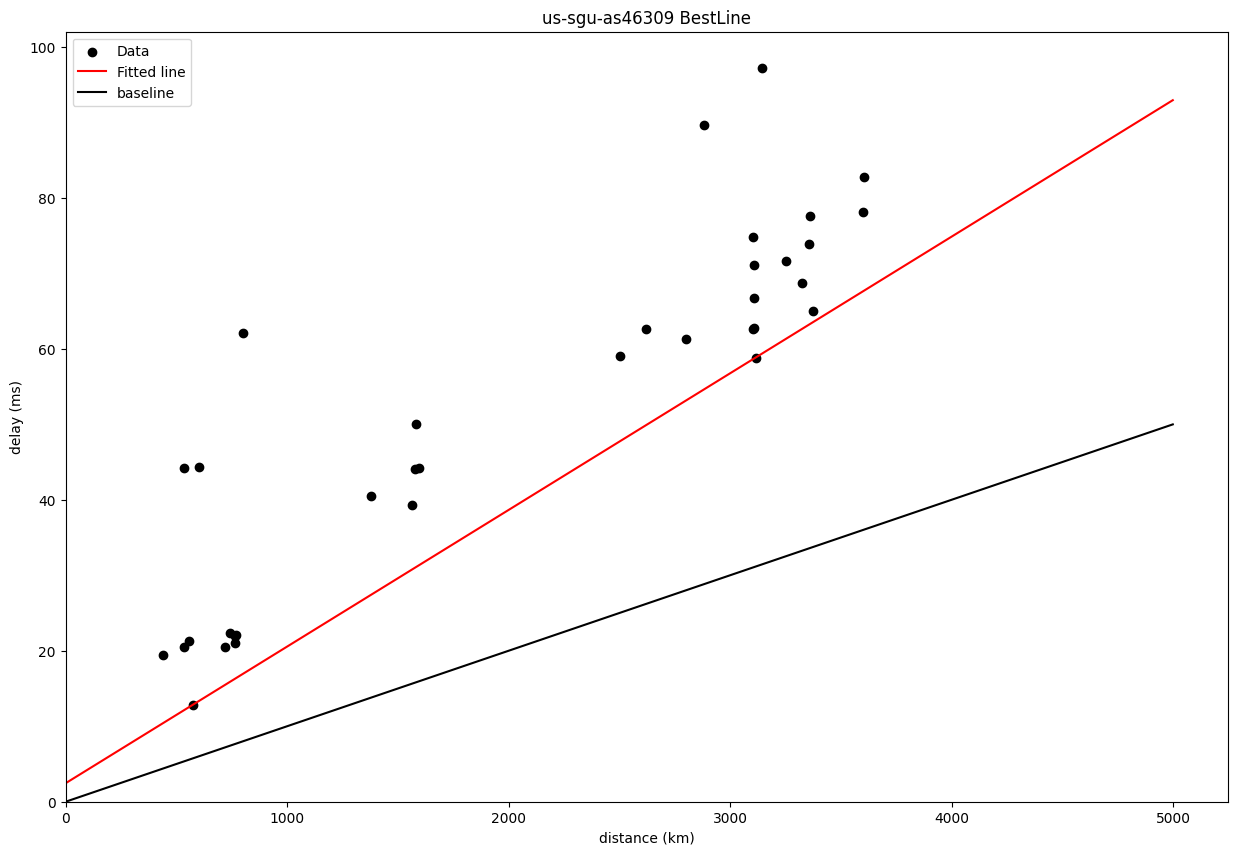

In [53]:
anchor = "us-sgu-as46309" if Name == "US" else "uk-slo-as202109"

distances = anchor_distances_delays_targets[anchor][0]
delays = anchor_distances_delays_targets[anchor][1]
m,b = anchor_best_lines[anchor]

plt.figure(figsize=(15, 10))
plt.scatter(distances, delays, color='black', label='Data')
plt.plot(range(0, 5000), [m * i + b for i in range(0, 5000)], color='red', label='Fitted line')
plt.plot(range(0, 5000), [0.01*i for i in range(0, 5000)], color='black', label='baseline')

plt.gca().set_xlim(left=0)  
plt.gca().set_ylim(bottom=0) 
plt.xlabel('distance (km)')
plt.ylabel('delay (ms)')
plt.title(f'{anchor} BestLine')
plt.savefig(f"{Name}_bestline.png")
plt.legend()

# Get non-self-intersecting polygon points for each anchor

In [54]:
def cal_centroid(polygon_points):
    n = len(polygon_points)  
    if n == 0: 
        return None

    sum_x = 0
    sum_y = 0

    for x, y in polygon_points:
        sum_x += x
        sum_y += y

    # 计算均值
    centroid_x = sum_x / n
    centroid_y = sum_y / n

    return (centroid_x, centroid_y)

def in_circle(x,y,circle):
    x0,y0,r = circle
    if (x-x0)**2 + (y-y0)**2 < r**2+1e-6:
        return True
    return False

def cal_circle_intersections(circle1, circle2):
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    if d > r1 + r2 or d < abs(r1 - r2):
        return None

    a = (r1**2 - r2**2 + d**2) / (2 * d)
    h = np.sqrt(r1**2 - a**2)
    x0 = x1 + a * (x2 - x1) / d
    y0 = y1 + a * (y2 - y1) / d

    intersection1 = (x0 + h * (y2 - y1) / d, y0 - h * (x2 - x1) / d)
    intersection2 = (x0 - h * (y2 - y1) / d, y0 + h * (x2 - x1) / d)

    return intersection1, intersection2

## get circle intersection points and the good circle,then get the polygon points

In [55]:
standard_lat1,standard_lat2,standard_lon0 = get_standard_lat_lon(anchors,loc_data)

anchor_polygons = {}
anchor_circles = {}
anchor_centroids = {}
error_distances = {}

for anchor,(distances,delays,targets) in anchor_distances_delays_targets.items():
    m,b = anchor_best_lines[anchor]
    circles = []
    # get circles
    for distances,delay,target in zip(distances,delays,targets):
        x0,y0 = to_aea(loc_data[target]["lng"],loc_data[target]["lat"],standard_lat1,standard_lat2,standard_lon0)
        estimate_r = (delay - b)/m
        circles.append((x0,y0,estimate_r))
    anchor_circles[anchor] = circles
    # calculate intersections
    intersection_points = []
    good_circles = set()
    for i,circle1 in enumerate(circles):
        for j,circle2 in enumerate(circles):
            if i != j:
                intersections = cal_circle_intersections(circle1,circle2)
                if intersections:
                    intersection_points.append(intersections[0])
                    intersection_points.append(intersections[1])
                    good_circles.add(circle1)
                    good_circles.add(circle2)
    polygon_points = []
    # calculate polygon points
    for i,intersection_point in enumerate(intersection_points):
        x,y = intersection_point
        in_all_good_circle = True
        for good_circle in good_circles:
            if not in_circle(x,y,good_circle):
                in_all_good_circle = False
                break
        if in_all_good_circle:
            polygon_points.append(intersection_point)
    anchor_polygons[anchor] = polygon_points

# cal centroid and error distance
for anchor,polygon_points in anchor_polygons.items():
    centroid = cal_centroid(polygon_points)
    lon,lat = to_lon_lat(centroid[0],centroid[1],standard_lat1,standard_lat2,standard_lon0)
    error_distance = distance_km(loc_data[anchor]["lng"],loc_data[anchor]["lat"],lon,lat)
    error_distance = distance_km_aea(loc_data[anchor]["lng"],loc_data[anchor]["lat"],lon,lat,standard_lat1,standard_lat2,standard_lon0)
    error_distances[anchor] = error_distance
    anchor_centroids[anchor] = centroid

In [56]:
error_values = list(error_distances.values())
error_keys = list(error_distances.keys())

mean_error_distance = np.mean(error_values)
median_error_distance = np.median(error_values)
min_error_distance = np.min(error_values)
max_error_distance = np.max(error_values)

min_key = error_keys[np.argmin(error_values)]
max_key = error_keys[np.argmax(error_values)]

tolerance = 10
median_indices = np.where(np.abs(error_values - median_error_distance) < tolerance)[0]

if median_indices.size > 0:
    median_key = error_keys[median_indices[0]]  # 取第一个匹配的键
else:
    median_key = None  # 如果没有找到，设置为 None
    print("No key found for median error distance.")


print(f"Mean error distance: {mean_error_distance:.2f} km")
print(f"Median error distance: {median_error_distance:.2f} km, key: {median_key}")
print(f"Min error distance: {min_error_distance:.2f} km, key: {min_key}")
print(f"Max error distance: {max_error_distance:.2f} km, key: {max_key}")

Mean error distance: 117.72 km
Median error distance: 32.77 km, key: us-lax-as15133
Min error distance: 0.52 km, key: us-sfo-as14907
Max error distance: 1025.35 km, key: us-sea-as2914


# Visualization

In [57]:
# us
def to_circle_points(lon,lat,radius_km,n_points=100):
    theta = np.linspace(0, 2 * np.pi, n_points)
    circle_lon = lon + (radius_km / 111.32) * np.cos(theta) / np.cos(np.radians(lat))
    circle_lat = lat + (radius_km / 111.32) * np.sin(theta)
    return circle_lon,circle_lat
    
anchor = min_key
polygon_points = anchor_polygons[anchor]
circles = anchor_circles[anchor]
centroid = anchor_centroids[anchor]
real_lon,real_lat = (loc_data[anchor]["lng"],loc_data[anchor]["lat"])

## plot one of the anchor points

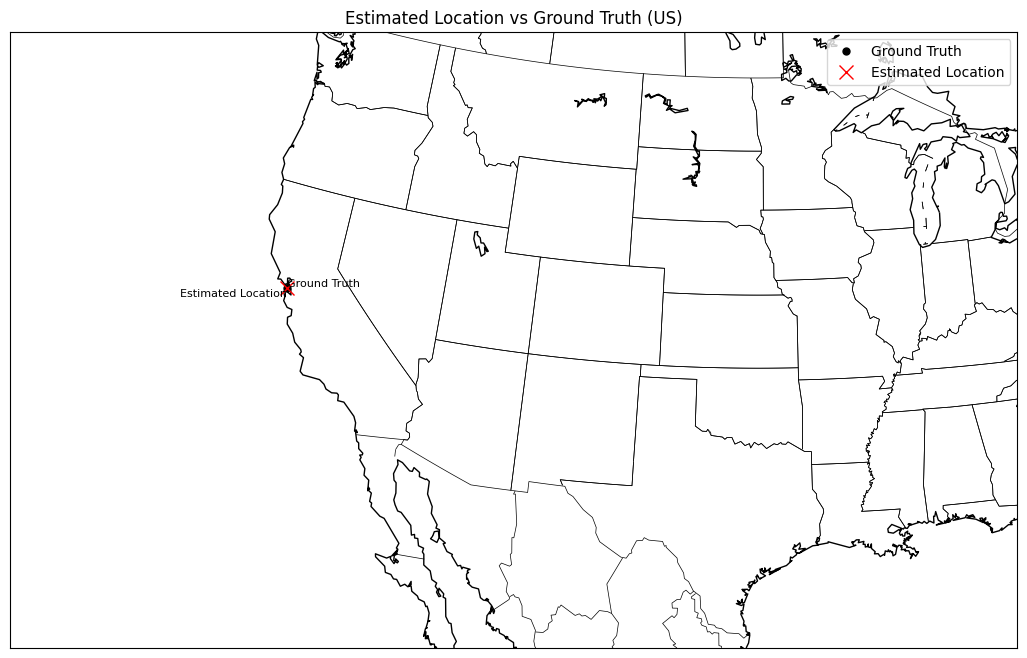

In [58]:
plt.figure(figsize=(15, 8))

if Name == "US":
    m = Basemap(projection='aea', resolution='l',
                lat_1=standard_lat1, lat_2=standard_lat2, lon_0=standard_lon0,
                llcrnrlon=-130, llcrnrlat=20, urcrnrlon=-80, urcrnrlat=50) # for us only
else:
    m = Basemap(projection='aea', resolution='l',
            lat_1=standard_lat1, lat_2=standard_lat2, lon_0=standard_lon0,
            llcrnrlon=-10, llcrnrlat=35, urcrnrlon=40, urcrnrlat=60) # for western europe only
# 绘制地图背景
m.drawcoastlines()
m.drawcountries()
m.drawstates()

lon, lat = real_lon,real_lat

# real
x, y = m(lon, lat)
m.plot(x, y, 'ko', markersize=5,label='Ground Truth')
plt.text(x, y, 'Ground Truth', fontsize=8, ha='left', va='bottom')

# estimated
lon, lat = to_lon_lat(centroid[0],centroid[1],standard_lat1,standard_lat2,standard_lon0)
x, y = m(lon, lat)
m.plot(x, y, 'rx', markersize=10,label='Estimated Location')
plt.text(x, y, 'Estimated Location', fontsize=8, ha='right', va='top')

# 显示地图
plt.title(f'Estimated Location vs Ground Truth ({Name})')
plt.savefig(f"{Name}_anchor_estimated_location.png")
plt.legend()
plt.show()

## plot all the circle intersection points

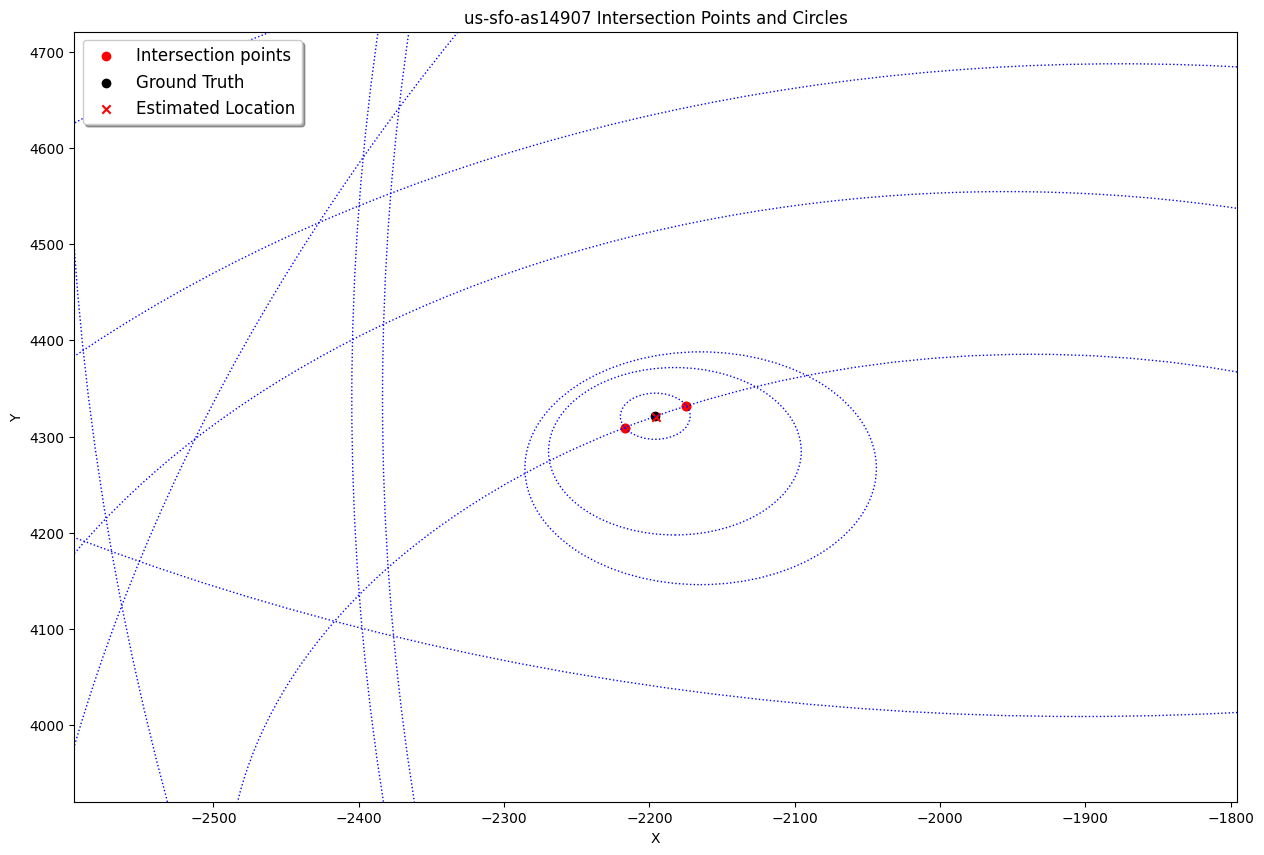

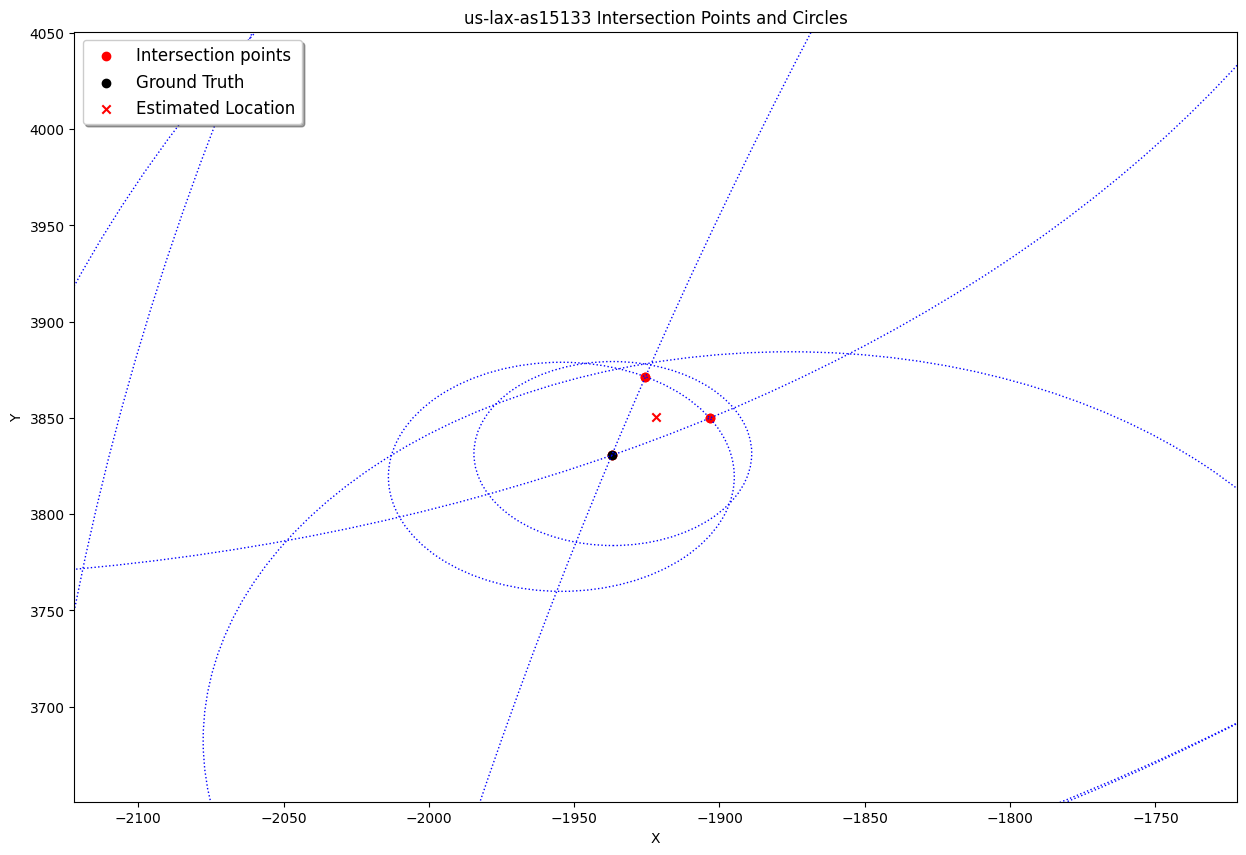

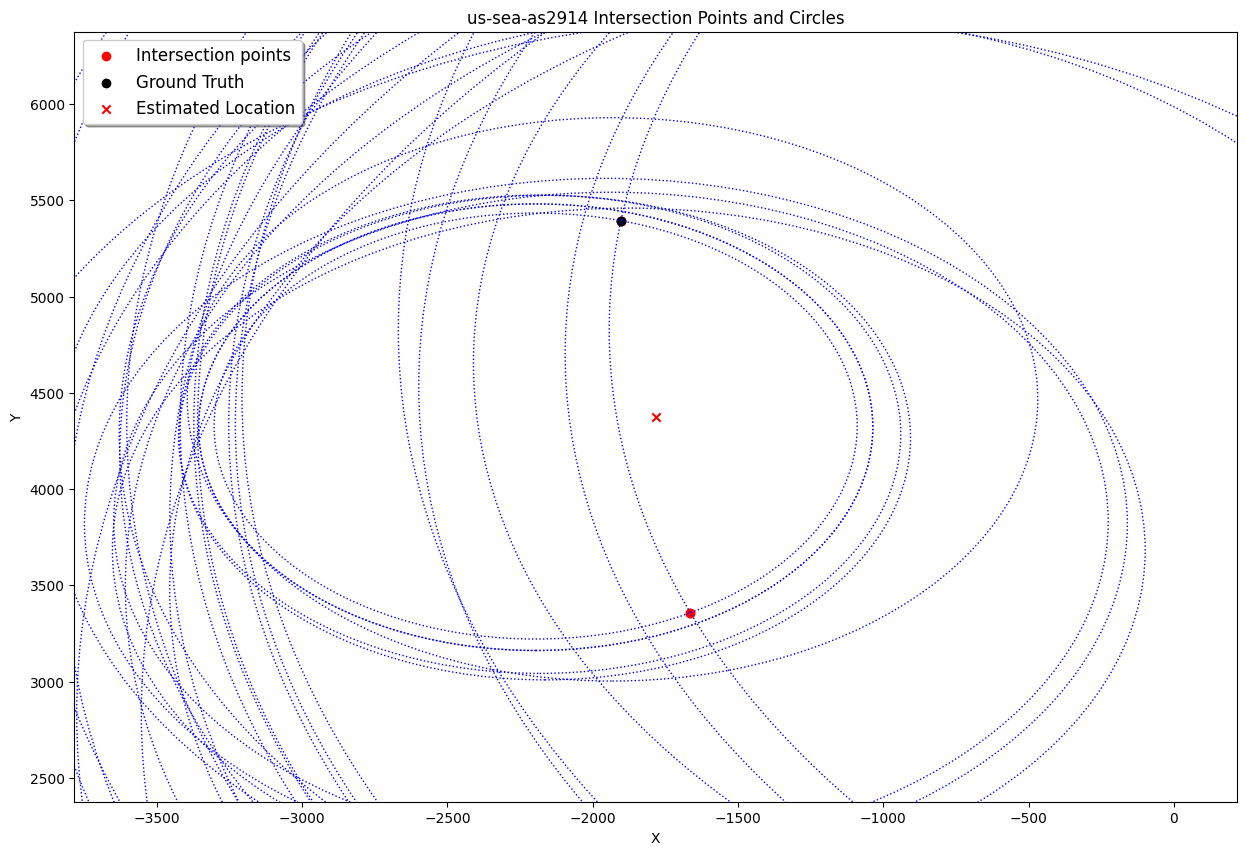

In [59]:
def plor_anchor(anchor,dx=500):
    polygon_points = anchor_polygons[anchor]
    circles = anchor_circles[anchor] 
    centroid = anchor_centroids[anchor]
    real_lon,real_lat = to_aea(loc_data[anchor]["lng"],loc_data[anchor]["lat"],standard_lat1,standard_lat2,standard_lon0)

    plt.figure(figsize=(15, 10))

    # lim
    min_x = min([x for x, y, r in circles])
    max_x = max([x for x, y, r in circles])
    min_y = min([y for x, y, r in circles])
    max_y = max([y for x, y, r in circles])

    # polygon points
    plt.scatter([x for x, y in polygon_points], [y for x, y in polygon_points], color='red', label='Intersection points')

    # ground truth 
    plt.scatter(real_lon, real_lat, color='black', label='Ground Truth',marker='o')

    # estimated location
    plt.scatter(centroid[0], centroid[1], color='red', label='Estimated Location',marker='x')

    # circles
    for x, y, r in circles:
        circle = plt.Circle((x, y), r, color='blue', fill=False,linestyle='dotted')
        plt.gca().add_artist(circle)
    
    plt.xlim(centroid[0] - dx, centroid[0] + dx)
    plt.ylim(centroid[1] - dx, centroid[1] + dx)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'{anchor} Intersection Points and Circles')
    plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)
    plt.savefig(f"{Name+anchor}_intersection_points_circles.png")
    plt.show()
plor_anchor(min_key,400)
plor_anchor(median_key,200)
plor_anchor(max_key,2000)

## plot CDF

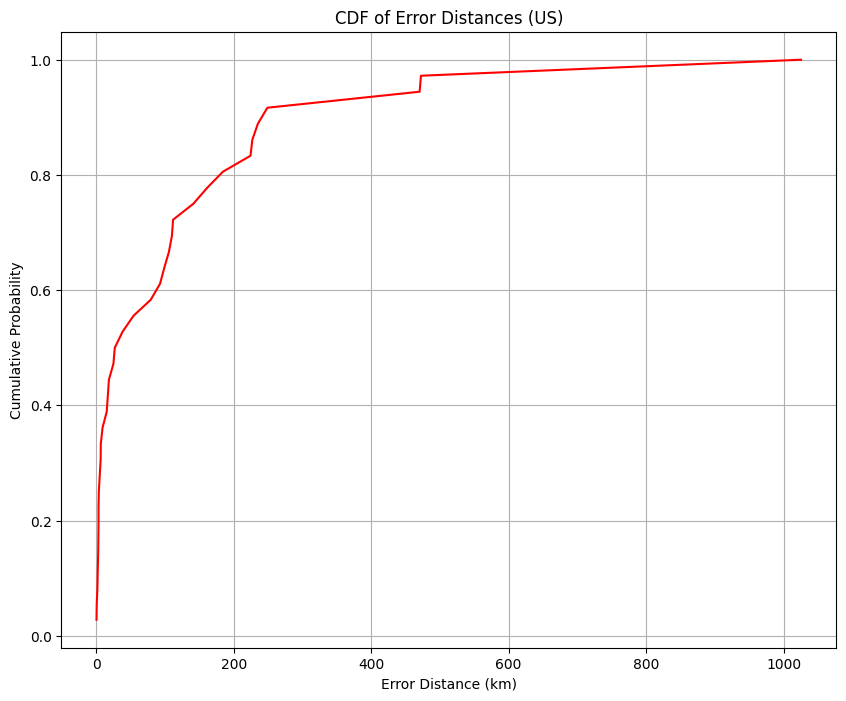

In [60]:
# 原始数据
data = list(error_distances.values())

# 将数据转换为 NumPy 数组并排序
data = np.sort(data)

# 计算累积频率
cdf = np.arange(1, len(data) + 1) / len(data)


# 可视化 CDF
plt.figure(figsize=(10, 8))
plt.plot(data, cdf, color='r')
plt.xlabel('Error Distance (km)')
plt.ylabel('Cumulative Probability')

plt.title(f'CDF of Error Distances ({Name})')
plt.savefig(f"{Name}anchor_cdf.png")
plt.grid()
plt.show()